In [75]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier,FMClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler, ChiSqSelector, PCA, Tokenizer, StopWordsRemover, Word2Vec
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import re
import matplotlib.pyplot as plt
import statistics

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Projekt

### Anna Mieszkalska, Bartosz Chądzyński, Witold Barcz

W niniejszej analizie weźmiemy pod uwagę dane Travel z bazy danych StackOverflow. Ogólny zamysł tego zbioru danych polega na pytaniach oraz odpowiedziach użytkowników na temat podróżowania oraz turystyki wraz ze wszystkimi szczegółami.

Skupimy się na trzech tabelach takich jak Posts, Users oraz Tags. Wybierzemy te zmienne, które będą pasowały do specyfiki projektu oraz przydadzą się w modelowaniu i analizie. Dodatkowo stworzymy własne zmienne w celu ułatwienia stworzenia klasyfikatorów. Naszym zadaniem będzie zbudowanie modelu przewidującego, czy na dane pytanie zostanie udzielona zaakceptowana odpowiedź. Poniżej umieszczamy opis zmiennych, które weźmiemy pod uwagę w analizie.

### Tabela Posts (22 kolumn, 128164 wierszy)


Zawiera głównie informacje na temat nieusuniętych pytań oraz odpowiedzi. W naszym przypadku będziemy brali pod uwagę tylko pytania oraz poniższe zmienne

- Id (identyfikator posta),
- PostTypeId (1 = Pytanie, 2 = Odpowiedź),
- AcceptedAnswerId (identyfikator zaakceptowanej odpowiedzi),
- CreationDate (data utworzenia),
- ClosedDate (data zamknięcia),
- Score (różnica pomiędzy pozytywnymi, a negatywnymi reakcjami pod postem),
- Body (treść posta),
- OwnerUserId (numer identyfikacyjny twórcy),
- Tags (tagi umieszczone w pytaniu),
- CommentCount (ilość komentarzy),
- Title (tytuł pytania),
- ViewCount (liczba wyświetleń).

### Tabela Users (12 kolumn, 105401 wierszy)
Zawiera liczne informacje odnośnie użytkowników portalu StackOverflow. Zmienne, które wykorzystamy w projekcie:

- Id (identyfikator),
- Location (lokalizacja użytkownika),
- UpVotes (liczba pozytywnych reakcji jakie otrzymał użytkownik),
- Views (liczba wyświetleń profilu użytkownika).

### Tabela Posts (5 kolumn, 1954 wierszy)
Posłuży nam ona jedynie do znalezienia najpopularniejszych tagów wykorzystując zmienną TagName i zliczając ilość wystąpień każdego tagu w tabeli.

In [4]:
spark = SparkSession.builder.appName("Travel").config("spark.jars.packages","com.databricks:spark-xml_2.12:0.17.0").getOrCreate()

Tworzymy trzy ramki danych ze zbioru TravelStack.

In [5]:
df_posts = spark.read.format("com.databricks.spark.xml").option("rowTag", "row").option("rootTag", "posts").load("../data/posts.xml")
df_users = spark.read.format("com.databricks.spark.xml").option("rowTag", "row").option("rootTag", "users").load("../data/users.xml")
df_tags = spark.read.format("com.databricks.spark.xml").option("rowTag", "row").option("rootTag", "tags").load("../data/tags.xml")

Poniżej przygotowujemy funkcje, które będą pomocne przy tworzeniu nowych kolumn w naszych danych:

Funkcja if_NaN zwraca 1, gdy wartość wejściowa nie jest wartością brakującą (NaN), a 0 w przeciwnym przypadku. Użyjemy jej do określenia, czy pytanie posiada zaakceptowaną odpowiedź (zmienna AcceptedAnswerId).

In [6]:
@udf(returnType='int')
def if_NaN(x):
    if x is not None:
        return 1
    else:
        return 0

Funkcja slen przyjmuje argument typu string, oblicza długość ciągu znaków i zwraca tę wartość jako liczbę całkowitą. Użyjemy jej dla kolumn Body i Title, aby uczynić je bardziej przydatnymi w modelowaniu.

In [7]:
@udf(returnType='int') 
def slen(s):
    return len(s)

Funkcja if_Tag sprawdza, czy dany tag znajduje się w kolumnie Tags. Jeśli tag jest obecny w ciągu znaków, funkcja zwraca 1, w przeciwnym razie zwraca 0. Bierzemy pod uwagę pięć najpopularniejszych tagów.

In [8]:
@udf(returnType='int')
def if_Tag1(x):
    tag = "<" + popular_tags[0][0] + ">"
    if tag in x:
        return 1
    else:
        return 0

@udf(returnType='int')
def if_Tag2(x):
    tag = "<" + popular_tags[1][0] + ">"
    if tag in x:
        return 1
    else:
        return 0

@udf(returnType='int')
def if_Tag3(x):
    tag = "<" + popular_tags[2][0] + ">"
    if tag in x:
        return 1
    else:
        return 0

@udf(returnType='int')
def if_Tag4(x):
    tag = "<" + popular_tags[3][0] + ">"
    if tag in x:
        return 1
    else:
        return 0

@udf(returnType='int')
def if_Tag5(x):
    tag = "<" + popular_tags[4][0] + ">"
    if tag in x:
        return 1
    else:
        return 0

Korzystając z tabeli Tags, znajdujemy najpopularniejsze tagi i przypisujemy je do zmiennej popular_tags.

In [9]:
popular_tags = df_tags.select(df_tags._TagName).sort("_Count", ascending = False).limit(5).collect()

## Selekcja zmiennych i przygotowanie danych

Zaktualizowana ramka danych "Posts" zawiera:
- tylko pytania (PostTypeId = 1),
- kolumnę logiczną AcceptedAnswerExist (1, jeśli istnieje, 0, jeśli brak danych) - będzie służyła jako kolumna etykiet w naszym modelu,
- zawiera długość treści w kolumnach Body i Title - ilość znaków może wpływać na chęć odpowiedzi użytkowników na dane pytanie,
- zawiera też treść pytań i ich tytuły. Na koniec spróbujemu użyć analizy semantycznej do stworzenia modelu klasyfikacyjnego
- posiada kolumnę logiczną IfClosed (1, jeśli pytanie jest zamknięte, 0, jeśli jeszcze nie) - przewidujemy, że zamknięte pytania mają większą szansę na posiadanie zaakceptowanej odpowiedzi,
- posiada nowe kolumny (typu bool), które określają, czy pytanie ma adekwatny tag - pytania oznaczone popularnymi tagami są prawdopodobnie chętniej oglądane przez użytkowników,
- zmienną CommentCount - im większa ilość komentarzy, tym większe prawdopodobieństwo zaakceptowanej odpowiedzi,
- Score oraz ViewCount - pytanie z dużym wynikiem oraz wyświetleniami ma duże prawdopodobieństwo uzyskania zaakceptowanej odpowiedzi.

In [41]:
df_posts_updated = df_posts.select(if_NaN("_AcceptedAnswerId").alias("AcceptedAnswerExist"), df_posts._Body, df_posts._Title, df_posts._AnswerCount,
slen("_Body").alias("BodyLen"), df_posts._CommentCount, df_posts._CreationDate, if_NaN("_ClosedDate").alias("IfClosed"),
df_posts._Id, df_posts._OwnerUserId, df_posts._PostTypeId, df_posts._Score, df_posts._Tags, slen("_Title").alias("TitleLen"),
df_posts._ViewCount) \
.withColumn("TagVisas",if_Tag1("_Tags")) \
.withColumn("TagUsa", if_Tag2("_Tags")) \
.withColumn("TagUk", if_Tag3("_Tags")) \
.withColumn("TagAir-travel", if_Tag4("_Tags")) \
.withColumn("TagCustoms-and-immigration", if_Tag5("_Tags")) \
.filter("_PostTypeId == 1") \
.filter("_OwnerUserId NOT LIKE 'NaN' ")

Zaktualizowana ramka danych "Users" zawiera kolumny:
- Id (na potrzeby łączenia tabel)
- UpVotes oraz Views (przewidujemy, że im większa ilość wyświetleń i pozytywnych reakcji użytkownika, tym większa szansa, że uzyska zaakceptowaną odpowiedź).

In [11]:
df_users_new = df_users.select("_Id", "_Location", "_UpVotes", "_Views")

Łączenie wcześniej stworzonych tabel "Posts" oraz "Users".

In [42]:
df_main = df_posts_updated.join(df_users_new, df_posts_updated._OwnerUserId == df_users_new._Id, 'left_outer')

Poniżej przedstawiamy gotową do analizy tabelę.

In [12]:
df_main.toPandas()

,AcceptedAnswerExist,_AnswerCount,BodyLen,_CommentCount,_CreationDate,IfClosed,_Id,_OwnerUserId,_PostTypeId,_Score,...,_ViewCount,TagVisas,TagUsa,TagUk,TagAir-travel,TagCustoms-and-immigration,_Id,_Location,_UpVotes,_Views
0,1,3,504,3,2011-06-21 22:30:38.687,0,8,26,1,15,...,12989,0,0,0,0,0,26,"Oxford, United Kingdom",19507,7234
1,1,2,1034,0,2011-07-03 13:21:51.543,0,780,26,1,26,...,6276,0,0,1,0,0,26,"Oxford, United Kingdom",19507,7234
2,0,4,1399,4,2011-07-05 23:19:11.723,0,823,26,1,10,...,1742,0,0,0,0,0,26,"Oxford, United Kingdom",19507,7234
3,1,5,908,0,2011-07-09 22:26:20.707,0,886,26,1,17,...,10271,0,0,0,0,0,26,"Oxford, United Kingdom",19507,7234
4,1,3,1961,1,2011-07-10 21:07:46.663,0,910,26,1,6,...,1857,0,0,0,0,0,26,"Oxford, United Kingdom",19507,7234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46740,0,0,206,4,2023-10-05 06:18:47.033,0,183941,139575,1,4,...,133,0,0,0,0,0,139575,None,0,0
46741,0,0,634,0,2023-11-16 14:36:11.810,1,184610,140604,1,2,...,48,1,0,0,0,0,140604,None,0,0
46742,1,1,516,7,2023-05-04 12:45:11.337,0,180981,135572,1,0,...,161,0,0,0,0,0,135572,None,0,2
46743,0,0,670,7,2023-06-18 12:15:38.257,0,181833,136645,1,1,...,159,0,0,0,0,1,136645,None,0,0


W większości modeli będziemy korzystać z dwóch podzbiorów powyższej tabeli. Poniżej ich definicje. W pierwszym wyrzucamy zmienne, które nie mają sensu przy budowie modelu klasyfikacyjnego, takie jak np. ID użytkownika. 

In [ ]:
df_classification = df_main.drop("_Body", "_Title","_Id", "_CreationDate","_OwnerUserId","_PostTypeId","_Tags","_Location")

Funkcje, które służą do usunięcia znaków specjalnych z treści pytań oraz wyekstrahowaniu samej treści z tagów HTML. 

In [63]:
@udf
def removeSpecialCharacters(x):
    cleaned_string = re.sub(r'[^a-zA-Z0-9\s]', ' ', x)
    return cleaned_string

@udf
def removeTags(x):
    return x[3:-4]

In [90]:
df_semantic = df_main.select("_Id", "AcceptedAnswerExist",removeTags(removeSpecialCharacters("_Body")).alias("Body"), removeSpecialCharacters("_Title").alias("Title"))

In [ ]:
df_all = df_main.select("_Id", "AcceptedAnswerExist",removeTags(removeSpecialCharacters("_Body")).alias("Body"), removeSpecialCharacters("_Title").alias("Title"), "_AnswerCount", "BodyLen", "_CommentCount", "IfClosed", "_Score", "_ViewCount", "TagAir-travel", "TagCustoms-and-immigration", "TagUk", "TagUsa", "TagVisas", "_UpVotes", '_Views')

## Wstępna analiza zmiennych

W tym rozdziale zajmiemy się analizą najbardziej interesujących statystycznie zmiennych poprzez zastosowanie wskaźników sumarycznych (średnia, mediana i odchylenie standardowe) oraz narysujemy histogramy.

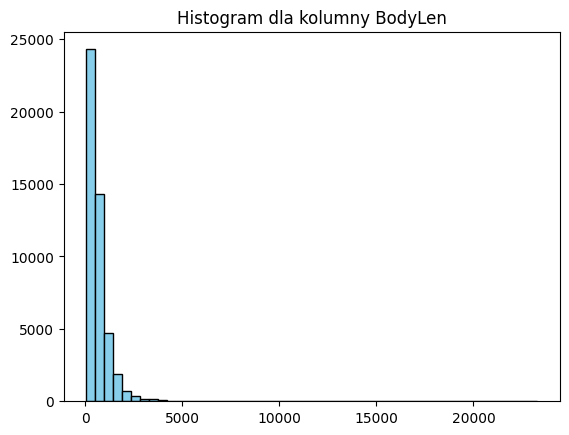

In [76]:
column_data = df_main.select("BodyLen").rdd.flatMap(lambda x: x).collect()

plt.hist(column_data, bins=50, color='skyblue', edgecolor='black')

plt.title('Histogram dla kolumny BodyLen')

plt.show()

In [77]:
srednia = statistics.mean(column_data)
mediana = statistics.median(column_data)
odchylenie_standardowe = statistics.stdev(column_data)

In [85]:
print("Średnia długość treści pytania wynosi: {:.2f}".format(srednia))
print("Mediana wynosi: {:.2f}".format(mediana))
print("Odchylenie standardowe wynosi: {:.2f}".format(odchylenie_standardowe))

Średnia długość treści pytania wynosi: 641.80
Mediana wynosi: 485.00
Odchylenie standardowe wynosi: 575.55


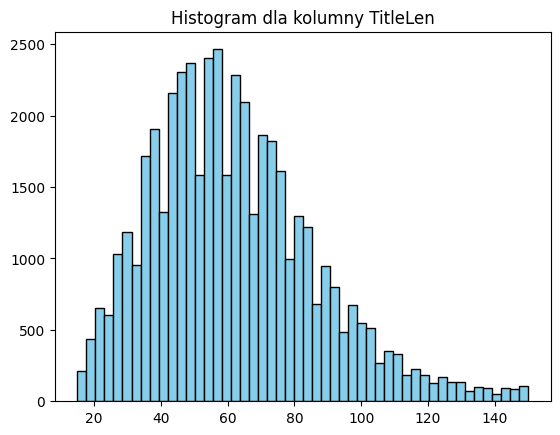

In [79]:
column_data2 = df_main.select("TitleLen").rdd.flatMap(lambda x: x).collect()

plt.hist(column_data2, bins=50, color='skyblue', edgecolor='black')

plt.title('Histogram dla kolumny TitleLen')

plt.show()

In [80]:
srednia2 = statistics.mean(column_data2)
mediana2 = statistics.median(column_data2)
odchylenie_standardowe2 = statistics.stdev(column_data2)

In [86]:
print("Średnia długość tytułu posta wynosi: {:.2f}".format(srednia2))
print("Mediana wynosi: {:.2f}".format(mediana2))
print("Odchylenie standardowe wynosi: {:.2f}".format(odchylenie_standardowe2))

Średnia długość tytułu posta wynosi: 61.68
Mediana wynosi: 59.00
Odchylenie standardowe wynosi: 24.60


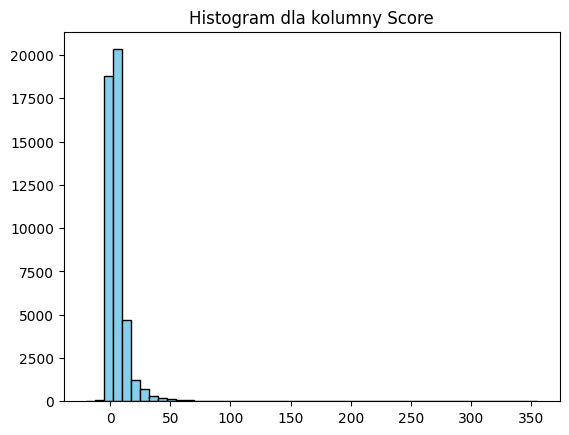

In [82]:
column_data3 = df_main.select("_Score").rdd.flatMap(lambda x: x).collect()

plt.hist(column_data3, bins=50, color='skyblue', edgecolor='black')

plt.title('Histogram dla kolumny Score')
#plt.xlabel('Wartość')
#plt.ylabel('Częstość')

plt.show()

In [83]:
srednia3 = statistics.mean(column_data3)
mediana3 = statistics.median(column_data3)
odchylenie_standardowe3 = statistics.stdev(column_data3)

In [87]:
print("Średnia różnica pomiędzy pozytywnymi i negatywnymi reakcjami wynosi: {:.2f}".format(srednia3))
print("Mediana wynosi: {:.2f}".format(mediana3))
print("Odchylenie standardowe wynosi: {:.2f}".format(odchylenie_standardowe3))

Średnia różnica pomiędzy pozytywnymi i negatywnymi reakcjami wynosi: 5.83
Mediana wynosi: 3.00
Odchylenie standardowe wynosi: 9.38


## Budowa modelu

Poniżej przedstawiamy funkcję, która buduje i ewaluuje model w oparciu o wybrany typ klasyfikatora. Zbiór treningowy dzielimy na 5 części i wykonujemy na nim walidację krzyżową. Ostateczne parametry modelu są wybierane na podstawie statystyki skuteczności predykcji. Będziemy uwzględniać:
- Skuteczność predykcji,
- AUC, czyli pole pod wykresem krzywej ROC. Krzywa ta nas informuje na temat zdolności do rozróżniania między klasami, przy różnych progach odcięcia. Oczywiście chcemy, aby AUC było jak najbliższe 1,
- Bookmaker Informedness, czyli suma True positive rate i True negative rate od której odejmujemy 1. To jest przede wszystkim metoda nieczuła na problem niezbalansowania klas, co występuje w naszym przypadku.

In [27]:
def buildAndEvaluateModel(train, test, classifierType, *args, **kwargs):
    classifier = classifierType(featuresCol="final_features", labelCol="AcceptedAnswerExist", *args, **kwargs)
    pipeline = Pipeline(stages=[classifier])
    
    binaryEvaluator = BinaryClassificationEvaluator(labelCol="AcceptedAnswerExist", rawPredictionCol="rawPrediction",
                                                    metricName="areaUnderROC")
    multiEvaluator = MulticlassClassificationEvaluator(labelCol="AcceptedAnswerExist", predictionCol="prediction",
                                                       metricName="accuracy")
    paramGrid = ParamGridBuilder().build() 
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=multiEvaluator,  
                              numFolds=5) 

    cvModel = crossval.fit(train)
    predictions = cvModel.transform(test)
    
    auc = binaryEvaluator.evaluate(predictions)
    print("AUC:", auc)
    accuracy = multiEvaluator.evaluate(predictions)
    print("Skuteczność:", accuracy)
    predictionAndLabels = predictions.select("prediction", "AcceptedAnswerExist").rdd.map(
        lambda row: (float(row[0]), float(row[1])))
    metrics = MulticlassMetrics(predictionAndLabels)
    confusionMatrix = metrics.confusionMatrix().toArray()
    print("Macierz pomyłek:\n", confusionMatrix)
    
    TP = confusionMatrix[0, 0]
    FN = confusionMatrix[0, 1]
    FP = confusionMatrix[1, 0]
    TN = confusionMatrix[1, 1]
    
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    informedness = TPR + TNR - 1
    print("Informedness:\n", informedness)

    return {"accuracy": accuracy, "AUC": auc, "confusionMatrix": confusionMatrix, "Informedness": informedness}

In [66]:
def simulations(df, assembling_vectors, model_types, *args, **kwargs):
    results = {}
    for model in model_types:
        train, test =  assembling_vectors(df)
        name = model.__name__
        print("\n\nWyniki dla "+ name)
        try:
            results[name] = buildAndEvaluateModel(train, test, model,  *args, **kwargs)
        except Exception as e:
            print(f"Błąd: {e}")
    return results

Na początek przeprowadźmy symulacje dla 5 wybranych klasyfikatorów. Będzie to regresja logistyczna, klasyfikator Factorization Machines, drzewo decyzyjne, oraz oparte na drzewach lasy losowe i Gradient Boost Trees. Przyjmujemy parametry domyślne i wszystkie kolumny naszego zbioru danych. Przeprowadzamy normalizacje na danych przed budowaniem modeli.

In [24]:
def normalization(df):
    columns_to_normalize = ["_AnswerCount", "_CommentCount", "BodyLen", "_Score", "TitleLen", "_ViewCount", "_UpVotes",
                            "_Views"]
    num_assembler = VectorAssembler(inputCols=columns_to_normalize, outputCol="numeric_features")
    scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_features")
    
    
    final_columns = ["scaled_features", "TagVisas", "TagUsa", "TagUk", "TagAir-travel", "TagCustoms-and-immigration",
                     "IfClosed"]
    final_assembler = VectorAssembler(inputCols=final_columns, outputCol="final_features")
    
    pipeline = Pipeline(stages=[num_assembler, scaler, final_assembler])
    transformedData = pipeline.fit(df).transform(df)
    train, test = transformedData.randomSplit([0.8, 0.2])
    
    return train, test

In [17]:
model_types = [LogisticRegression, FMClassifier, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier]
results_of_simulations = simulations(df_classification, normalization, model_types)



Wyniki dla LogisticRegression
AUC: 0.7425692459126626
Skuteczność: 0.6894776359540921
Macierz pomyłek:
 [[4925.  709.]
 [2186. 1503.]]
Informedness:
 0.28158439163222404


Wyniki dla FMClassifier
AUC: 0.7567089909239982
Skuteczność: 0.6951625013407702
Macierz pomyłek:
 [[4761.  873.]
 [1969. 1720.]]
Informedness:
 0.3112989398583301


Wyniki dla DecisionTreeClassifier
AUC: 0.7521847036248283
Skuteczność: 0.7948085380242411
Macierz pomyłek:
 [[4297. 1337.]
 [ 576. 3113.]]
Informedness:
 0.6065509305168355


Wyniki dla RandomForestClassifier
AUC: 0.8483989906382017
Skuteczność: 0.7937359219135471
Macierz pomyłek:
 [[4277. 1357.]
 [ 566. 3123.]]
Informedness:
 0.6057118164865314


Wyniki dla GBTClassifier
AUC: 0.8624501571558576
Skuteczność: 0.7974900783009761
Macierz pomyłek:
 [[4341. 1293.]
 [ 595. 3094.]]
Informedness:
 0.6092102099007182


Teraz przed zbudowaniem modeli, wybierzemy podzbiór zmiennych typu binarnego za pomocą testów chi-kwadrat wykonanych ze zmienną objaśnianą. Wybierzemy 3 najistotniejsze cechy.

In [29]:
def selecting_columns(df):
    columns_to_normalize = ["_AnswerCount", "_CommentCount", "BodyLen", "_Score", "TitleLen", "_ViewCount", "_UpVotes",
                            "_Views"]
    num_assembler = VectorAssembler(inputCols=columns_to_normalize, outputCol="numeric_features")
    scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_features")
    
    
    binaryFeatures = ['IfClosed', 'TagVisas', 'TagUsa', 'TagUk', 'TagAir-travel', 'TagCustoms-and-immigration']
    binaryFeaturesDF = df_classification.select(*binaryFeatures, "AcceptedAnswerExist")
    
    binaryAssembler = VectorAssembler(inputCols=binaryFeatures, outputCol="binaryFeatures")
    df_binary = binaryAssembler.transform(binaryFeaturesDF)
    
    selector = ChiSqSelector(numTopFeatures=3, featuresCol="binaryFeatures", labelCol="AcceptedAnswerExist", outputCol="selectedBinaryFeatures")
    selectedBinaryFeatures = [binaryFeatures[i] for i in selector.fit(df_binary).selectedFeatures]
    
    final_columns = ["scaled_features"]
    final_columns.extend(selectedBinaryFeatures)
    final_assembler = VectorAssembler(inputCols=final_columns, outputCol="final_features")
    
    pipeline = Pipeline(stages=[num_assembler, scaler, final_assembler])
    transformedData = pipeline.fit(df).transform(df)
    train, test = transformedData.randomSplit([0.8, 0.2])
    
    return train, test

In [30]:
model_types = [LogisticRegression, FMClassifier, DecisionTreeClassifier, RandomForestClassifier]
results_of_simulations_selected_features = simulations(df_classification, selecting_columns, model_types)



Wyniki dla LogisticRegression
AUC: 0.7518655229225865
Skuteczność: 0.6914046121593291
Macierz pomyłek:
 [[5070.  681.]
 [2263. 1526.]]
Informedness:
 0.2843305987061633


Wyniki dla FMClassifier
AUC: 0.7579358678107144
Skuteczność: 0.6985332911258837
Macierz pomyłek:
 [[4882.  877.]
 [1980. 1738.]]
Informedness:
 0.3151722387700857


Wyniki dla DecisionTreeClassifier
AUC: 0.7615222905430096
Skuteczność: 0.7994371685247321
Macierz pomyłek:
 [[4255. 1377.]
 [ 476. 3131.]]
Informedness:
 0.6235386389627493


Wyniki dla RandomForestClassifier
AUC: 0.8432627285222636
Skuteczność: 0.7893267475571781
Macierz pomyłek:
 [[4201. 1444.]
 [ 518. 3150.]]
Informedness:
 0.6029770316229319


Przy budowie modelu GBT występuje problem z brakiem pamięci przy rozgłaszaniu tabel. Wyłączamy automatyczny braodcasting.

In [35]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [38]:
model_types = [GBTClassifier]
results_of_simulations_selected_GBT = simulations(df_classification, selecting_columns, model_types)



Wyniki dla GBTClassifier
AUC: 0.8604831639802557
Skuteczność: 0.7928678197736494
Macierz pomyłek:
 [[4327. 1320.]
 [ 620. 3099.]]
Informedness:
 0.5995360834977328


In [40]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "10485760")

Teraz zbudujemy modele, jednak z mniejszą ilością zmiennych. Wykorzystamy metodę PCA do zmniejszenia wymiaru zmiennych numerycznych.

In [18]:
def dimensionReduction(df, pcaK=3):
    columns_to_normalize = ["_AnswerCount", "_CommentCount", "BodyLen", "_Score", "TitleLen", "_ViewCount", "_UpVotes",
                            "_Views"]
    num_assembler = VectorAssembler(inputCols=columns_to_normalize, outputCol="numeric_features")
    scaler = StandardScaler(inputCol="numeric_features", outputCol="scaledFeatures", withStd=True, withMean=True)
    pca = PCA(k=pcaK, inputCol="scaledFeatures", outputCol="pcaFeatures")
    
    final_columns = ["pcaFeatures", "TagVisas", "TagUsa", "TagUk", "TagAir-travel", "TagCustoms-and-immigration",
                     "IfClosed"]
    final_assembler = VectorAssembler(inputCols=final_columns, outputCol="final_features")
    
    pipeline = Pipeline(stages=[num_assembler, scaler, pca, final_assembler])
    transformedData = pipeline.fit(df).transform(df)
    train, test = transformedData.randomSplit([0.8, 0.2])
    
    return train, test

In [23]:
model_types = [LogisticRegression, FMClassifier, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier]
results_of_simulations_pca = simulations(df_classification, dimensionReduction, model_types)



Wyniki dla LogisticRegression
AUC: 0.7411358543603077
Skuteczność: 0.683152520740268
Macierz pomyłek:
 [[5044.  648.]
 [2331. 1379.]]
Informedness:
 0.2578541216404353


Wyniki dla FMClassifier
AUC: 0.7376280246408327
Skuteczność: 0.6838219559169698
Macierz pomyłek:
 [[4940.  729.]
 [2226. 1451.]]
Informedness:
 0.2660210671063967


Wyniki dla DecisionTreeClassifier
AUC: 0.3510274133494749
Skuteczność: 0.6929474025272707
Macierz pomyłek:
 [[4414. 1316.]
 [1527. 2002.]]
Informedness:
 0.3376311064097677


Wyniki dla RandomForestClassifier
AUC: 0.7351761722915304
Skuteczność: 0.6873298429319372
Macierz pomyłek:
 [[4808.  977.]
 [2009. 1756.]]
Informedness:
 0.2975160148802658


Wyniki dla GBTClassifier
AUC: 0.7479848126815702
Skuteczność: 0.6871113017370791
Macierz pomyłek:
 [[4505. 1079.]
 [1839. 1903.]]
Informedness:
 0.31532091767116555


Ponieważ w modelu drzewa decyzyjnego wychodzi absurdalnie niska wartość AUC (poniżej 0.5, mimo nie najgorszych wartości pozostałych statystyk), spróbujemy zbudować model jeszcze raz. 

In [92]:
model_types = [DecisionTreeClassifier]
results_of_simulations_pca2 = simulations(df_classification, dimensionReduction, model_types)



Wyniki dla DecisionTreeClassifier
AUC: 0.35942352140172495
Skuteczność: 0.6821870995301154
Macierz pomyłek:
 [[4466. 1267.]
 [1709. 1922.]]
Informedness:
 0.30832954187401995


Na koniec spróbujemy stworzyć model jedynie z użyciem treści postów. Wykorzystamy do tego narzędzia służące do analizy semantycznej. W szczególności najpierw dokonamy tokenizacji słów, następnie wyrzucimy słowa nie wnoszące nic do kontekstu (spójniki, zaimki itp.). Na koniec dokonamy wektoryzacji treści postów za pomocą algorytmu Word2Vec. Do klasyfikacji wykorzystamy te same algorytmy co poprzednio. 

In [88]:
def embeddings(df):

    tokenizer1 = Tokenizer(inputCol="Body", outputCol="words1")
    remover1 = StopWordsRemover(inputCol="words1", outputCol="filtered_words1")
    word2Vec1 = Word2Vec(inputCol="filtered_words1", outputCol="features1", vectorSize=100, minCount=5)
    
    tokenizer2 = Tokenizer(inputCol="Title", outputCol="words2")
    remover2 = StopWordsRemover(inputCol="words2", outputCol="filtered_words2")
    word2Vec2 = Word2Vec(inputCol="filtered_words2", outputCol="features2", vectorSize=100, minCount=5)
    
    vectorAssembler = VectorAssembler(inputCols=["features1", "features2"], outputCol="final_features")
    
    pipeline = Pipeline(stages=[tokenizer1, remover1, word2Vec1, tokenizer2, remover2, word2Vec2, vectorAssembler])
    transformedData = pipeline.fit(df).transform(df)
    train, test = transformedData.randomSplit([0.8, 0.2])
    
    return train, test

In [91]:
model_types = [LogisticRegression, FMClassifier, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier]
results_of_simulations_semantic = simulations(df_semantic, embeddings, model_types)



Wyniki dla LogisticRegression
AUC: 0.7343730987214051
Skuteczność: 0.6782853431478675
Macierz pomyłek:
 [[4302. 1224.]
 [1748. 1964.]]
Informedness:
 0.30759645625070187


Wyniki dla FMClassifier
AUC: 0.7096447602778394
Skuteczność: 0.647445570165984
Macierz pomyłek:
 [[3230. 2373.]
 [ 898. 2777.]]
Informedness:
 0.332123145885161


Wyniki dla DecisionTreeClassifier
AUC: 0.6067503525864754
Skuteczność: 0.6618574329379074
Macierz pomyłek:
 [[3847. 1773.]
 [1391. 2346.]]
Informedness:
 0.31229586409636445


Wyniki dla RandomForestClassifier
AUC: 0.7247507549010787
Skuteczność: 0.6747065790890492
Macierz pomyłek:
 [[4524. 1126.]
 [1895. 1742.]]
Informedness:
 0.2796741455201093


Wyniki dla GBTClassifier
AUC: 0.7182926297618348
Skuteczność: 0.6638228941684665
Macierz pomyłek:
 [[3957. 1576.]
 [1537. 2190.]]
Informedness:
 0.3027675350923946


## Wyniki

Najpierw spójrzmy na wyniki dla modeli, które uwzględniają wszystkie zmienne, które zostały po wstępnej selekcji. Widać, że modele oparte na drzewach są o wiele lepsze w zasadzie w każdym z kryteriów. Skuteczność i kryterium Informedness dają podobne rezultaty, choć w każdym z nich najlepsze są modele GBT. Natomiast las losowy daje wyjątkowo dużą wartość, jeśli chodzi o pole pod krzywą ROC. 

Tabela metryk, dla modelu z  uwzględnieniem wszystkich zmiennych: 

| Metryka     | Regresja Logistyczna | Factorial Matrix | Drzewo Decyzyjne   | Las Losowy         | Gradient-Boosted Trees  |
|-------------|----------------------|------------------|--------------------|--------------------|-------------------------|
| Skuteczność | 0.6895               | 0.6952           | 0.7948 | 0.7937| 0.7975                  |
| AUC         | 0.7426 | 0.7567 | 0.7521 | 0.8484 | 0.7974                  |
| Informedness| 0.2816 | 0.3113 | 0.6066 | 0.6057 | 0.6092                  |

W przypadku modelu, w którym wyselekcjonowaliśmy zmienne binarne, w większości statystyki są zbliżone do poprzednich. Niemniej zwykle są nieco lepsze lub chociaż niewiele gorsze od poprzednich. Znacząca poprawa nastąpiła, jeśli chodzi o pole pod krzywą ROC w modelu Gradient-Boosted Trees (z 0.80 na 0.86). Być może rzeczywiście na początku było zbyt dużo cech, co doprowadziło do lekkiego przeuczenia, choć podkreślmy, że nie są to duże różnice.

Tabela metryk, dla modelu z wybranymi zmiennymi binarnymi: 

| Metryka     | Regresja Logistyczna | Factorial Matrix | Drzewo Decyzyjne   | Las Losowy | Gradient-Boosted Trees |
|-------------|----------------------|------------------|--------------------|------------|------------------------|
| Skuteczność | 0.6914               | 0.6985           | 0.7994 | 0.7893     | 0.7929                 |
| AUC         | 0.7519               | 0.7579           | 0.7615 | 0.8433     | 0.8604                |
| Informedness| 0.2843               | 0.3152           | 0.6235 | 0.6029     | 0.5995                 |

W przypadku danych po redukcji wymiaru wyniki pogorszyły się, czasem znacząco. Mamy też jedną anomalię, która zdarzyła się dwukrotnie, czyli bardzo niska wartość AUC w przypadku drzewa decyzyjnego. Trudno ją wytłumaczyć patrząc na inne statystyki. Tym bardziej, że drzewo ma najwyższą wartość statystyki Informedness. Poza tym wszystkie algorytmy oparte na drzewach zaliczyły duży spadek, jeśli chodzi o skuteczność. Jest to coś, co się zdarza często ze względu na charakter tych algorytmów. Są one tak stworzone, aby radzić sobie z duża ilością danych wejściowych, ponieważ większa ilość danych daje większą liczbę potencjalnych węzłów. Poza tym właśnie ich największą przewagą jest możliwość modelowania nieliniowych zależności, w przeciwieństwie do większości klasycznych algorytmów. Kiedy użyliśmy metody liniowej PCA, niejako odebraliśmy im tą przewagę.

Tabela metryk, dla modelu z redukcją wymiaru: 

| Metryka         | Regresja Logistyczna | FMClassifier       | Drzewo Decyzyjne   | Las Losowy         | Gradient-Boosted Trees |
|-----------------|----------------------|--------------------|--------------------|--------------------|------------------------|
| Skuteczność     | 0.6832               | 0.6838             | 0.6929             | 0.6873             | 0.6871                 |
| AUC             | 0.7411               | 0.7376             | 0.3510             | 0.7352             | 0.7480                 |
| Informedness    | 0.2579               | 0.2660             | 0.3376             | 0.2975             | 0.3153                 |


Na koniec jeszcze przedstawmy wyniki próby użycia analizy semantycznej. Jak widać są one zwykle nieco gorsze. Zdarzają się przypadki lepszych wartości statystyk. W szczególności regresja logistyczna i factorial matrix dają lepszy wynik w krytetrium Informedness. Jednak należy pamiętać, że te wyniki są i tak niezłe jak na to, że nie użyliśmy żadnych innych danych poza samą treścią tekstu. Minusem takiego podejścia jest oczywiście złożoność. Sam proces wektroyzacji trwał długo, a jeszcze należy dorzucić często skomplikowane algorytmy klasyfikacyjne.  

| Metryka         | Regresja Logistyczna | FMClassifier       | Drzewo Decyzyjne   | Las Losowy         | Gradient-Boosted Trees |
|-----------------|----------------------|--------------------|--------------------|--------------------|------------------------|
| Skuteczność     | 0.6783               | 0.6474             | 0.6619             | 0.6747             | 0.6638                 |
| AUC             | 0.7344               | 0.7096             | 0.6068             | 0.7248             | 0.7183                 |
| Informedness    | 0.3076               | 0.3321             | 0.3123             | 0.2797             | 0.3028                 |


## Podsumowanie

Zdecydowanie najlepszymi modelami okazały się te oparte na drzewach. Patrząc całościowo, gdybyśmy mieli wybrać jeden model z tych przetestowanych przez nas, byłby to prawdopodobnie las losowy lub GBT, przy użyciu wcześniejszej selekcji cech za pomocą testu Chi-kwadrat. Przed wykonaniem symulacji baliśmy się tego, że złożone metody przy tak dużej ilości danych przeuczą się, ale ten problem jakoś szczególnie nie występował. Ponieważ mamy niezbalansowane klasy, to skuteczność może nie jest najlepszą statystyką do oceny, jednak kiedy uzyskujemy wyniki ok. 0.60 w kryterium Bookmaker Informedness i ok. 0.85 AUC, to wydaje się, że model ten ma istotną wartość analityczną.